# I used google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Root = '/content/drive/MyDrive/brain_tumor_dataset/'
os.chdir(Root)

# important liberals

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib

# import dataset

In [ ]:
data_path = pathlib.Path('/content/drive/MyDrive/brain_tumor_dataset/')

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    seed=123,
    shuffle=True,
    image_size = (224, 224),
    batch_size = 68
)

Found 253 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names

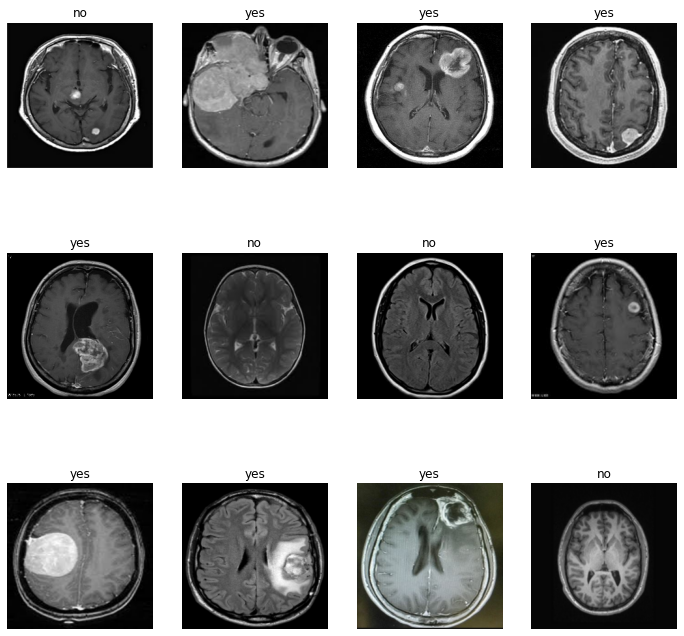

In [ ]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# split the dataset

In [ ]:
def split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=699):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size, seed=123)
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [ ]:
train_ds, test_ds, val_ds = split_data(dataset)

# EDA

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# build a model

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet")
vgg16.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.vgg16.preprocess_input(
    inputs, data_format=None)

x = vgg16(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
outputs = tf.keras.layers.Dense(2, activation="sigmoid")(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=1, mode='auto')

cb = [checkpoint, early]

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [ ]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks = cb)

Epoch 1/30
3/3 [==============================] - 93s 30s/step - loss: 22.3165 - accuracy: 0.6618
Epoch 2/30
3/3 [==============================] - 91s 30s/step - loss: 11.9812 - accuracy: 0.4853
Epoch 3/30
3/3 [==============================] - 91s 30s/step - loss: 1.8062 - accuracy: 0.7647
Epoch 4/30
3/3 [==============================] - 91s 30s/step - loss: 1.5454 - accuracy: 0.7549
Epoch 5/30
3/3 [==============================] - 91s 30s/step - loss: 0.6236 - accuracy: 0.8088
Epoch 6/30
3/3 [==============================] - 91s 30s/step - loss: 0.6810 - accuracy: 0.7451
Epoch 7/30
3/3 [==============================] - 91s 30s/step - loss: 0.3289 - accuracy: 0.8529
Epoch 8/30
3/3 [==============================] - 91s 30s/step - loss: 0.3854 - accuracy: 0.8235
Epoch 9/30
3/3 [==============================] - 91s 30s/step - loss: 0.3486 - accuracy: 0.8480
Epoch 10/30
3/3 [==============================] - 91s 30s/step - loss: 0.2782 - accuracy: 0.8725
Epoch 11/30
3/3 [==========

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 26s 26s/step - loss: 0.0746 - accuracy: 0.9796


[0.07462364435195923, 0.9795918464660645]